In [1]:
# import pystan
import stanity
n_jobs = 4
import pandas as pd
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = "Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
            "For each parameter, n_eff is a crude measure of effective sample size,\n"\
            "and Rhat is the potential scale reduction factor on split chains (at \n"\
            "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer

In [3]:
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    CIs = scoreatpercentile(model_fit[var], ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(model_fit['Y_sim'].shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5)
    ax.fill_between(x, CIs[25], CIs[75])

In [4]:
from scipy.stats import norm, truncnorm

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e66b04252e7dda9281ce8f26cd55007 NOW.


NOT reusing model.
Ran in 48.031 sec.
Inference for Stan model: anon_model_8e66b04252e7dda9281ce8f26cd55007.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.04  6.5e-4   0.03  -0.03   0.01   0.04   0.06    0.1   2437    1.0
sigma    1.0  4.2e-4   0.02   0.96   0.99    1.0   1.02   1.05   2584    1.0
lp__  -507.9    0.02   0.98 -510.5 -508.2 -507.6 -507.2 -507.0   2021    1.0

Samples were drawn using NUTS at Sat Nov  5 06:19:35 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


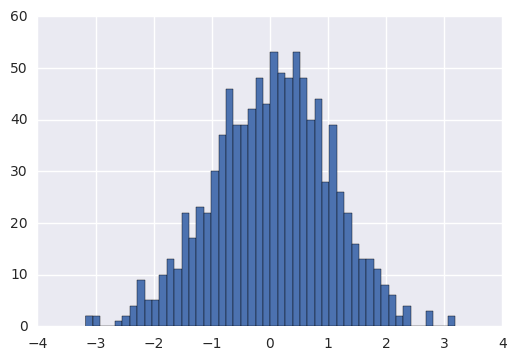

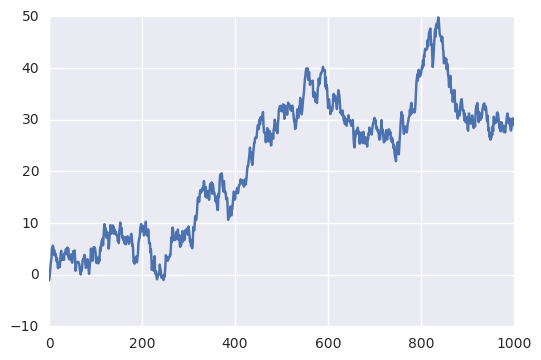

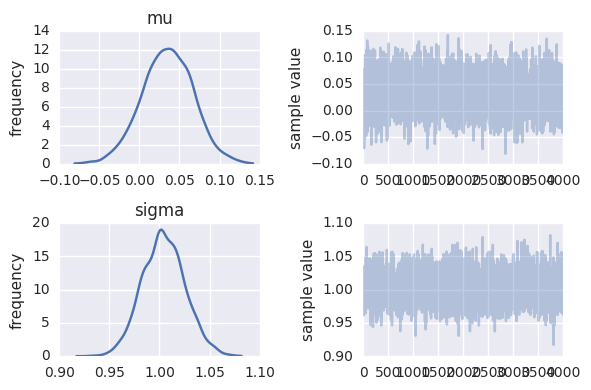

In [5]:
#### Random walk
mu = 0
sigma = 1
n = 1000

data = norm(loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real mu;
    real<lower = 0> sigma;
    
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        Y[t+1] ~ normal(mu+Y[t],sigma);
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7955e186edc1a57d41230efb2263b3d3 NOW.


NOT reusing model.
Ran in 48.033 sec.
Inference for Stan model: anon_model_7955e186edc1a57d41230efb2263b3d3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.01  1.3e-3   0.07   3.88   3.97   4.01   4.06   4.14   2356    1.0
sigma   1.96  1.0e-3   0.05   1.86   1.92   1.96   1.99   2.06   2562    1.0
lp__   -2016    0.02    1.0  -2018  -2016  -2015  -2015  -2015   1916    1.0

Samples were drawn using NUTS at Wed Nov  2 10:02:02 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


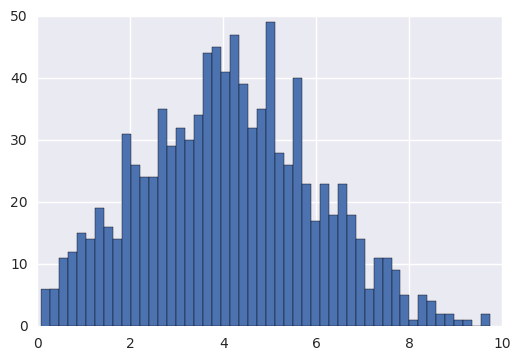

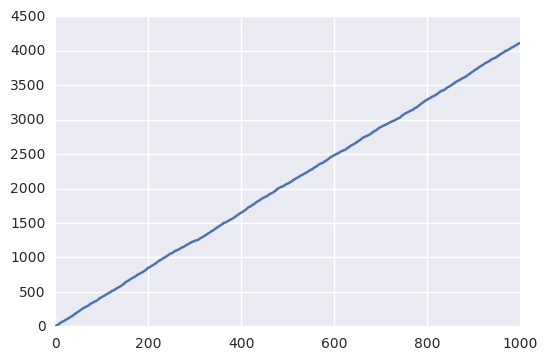

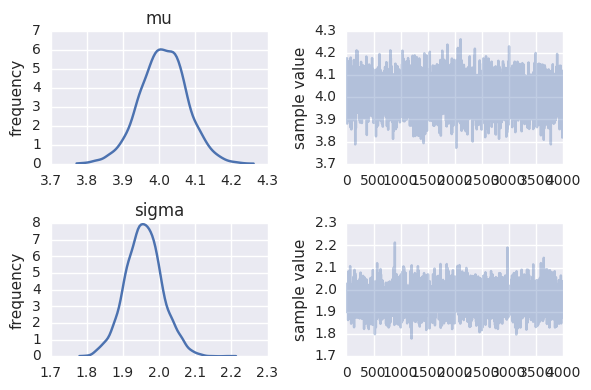

In [5]:
#### Random walk, positive steps
mu = 4
sigma = 2
n = 1000


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
  
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower = 0> sigma;
    
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += normal_lpdf( Y[t+1]-Y[t] | mu, sigma);
        target += -normal_lccdf(0 | mu, sigma);
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

Reusing model.
Ran in 3.050 sec.
Inference for Stan model: anon_model_7350368b1eaf8cbe024e025c45b4d6db.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      5.01  1.5e-3   0.07   4.88   4.97   5.01   5.06   5.15   2180    1.0
sigma   2.01  1.0e-3   0.05   1.91   1.97    2.0   2.04   2.11   2433    1.0
theta    0.8  2.4e-4   0.01   0.77   0.79    0.8   0.81   0.82   2712    1.0
lp__   -1457    0.03   1.19  -1460  -1458  -1457  -1456  -1456   1799    1.0

Samples were drawn using NUTS at Wed Nov  2 09:07:56 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


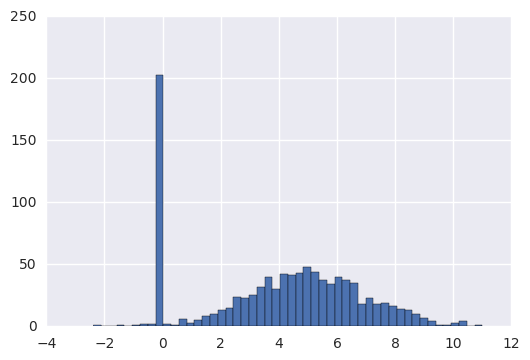

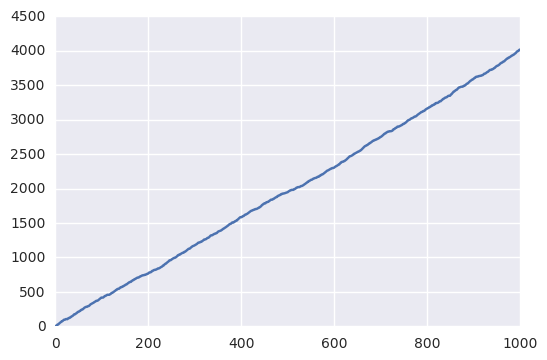

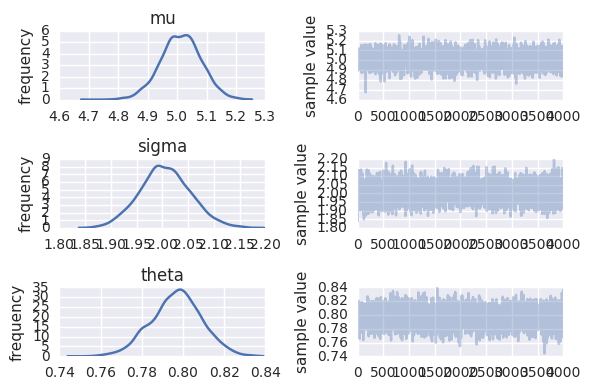

In [18]:
### Random walk, possibility of no step

theta = .8
mu = 5
sigma = 2
n = 1000

improvement = rand(n)<theta

data = norm(loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
  
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real mu;
    real<lower = 0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += log_mix(theta, normal_lpdf(Y[t+1]-Y[t] | mu, sigma), 
                      normal_lpdf(Y[t+1]-Y[t] | 0, 0.01));
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 0,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55966d7cbcb107a5050fe4d2db5fb265 NOW.


NOT reusing model.
Ran in 51.356 sec.
Inference for Stan model: anon_model_55966d7cbcb107a5050fe4d2db5fb265.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.99  6.6e-4   0.04   4.91   4.96   4.99   5.01   5.06   3007    1.0
sigma   1.03  4.9e-4   0.03   0.98   1.01   1.03   1.05   1.08   2853    1.0
theta    0.8  2.1e-4   0.01   0.77   0.79    0.8   0.81   0.82   3219    1.0
lp__  -775.9    0.03   1.23 -779.2 -776.4 -775.6 -775.0 -774.6   2110    1.0

Samples were drawn using NUTS at Wed Nov  2 10:02:55 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


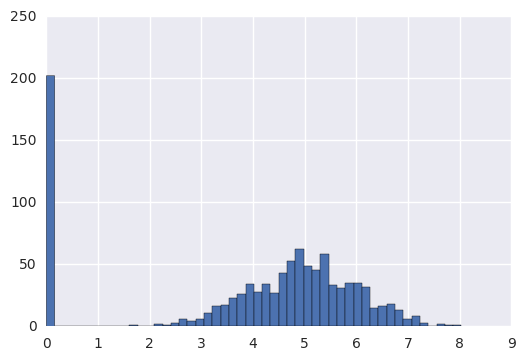

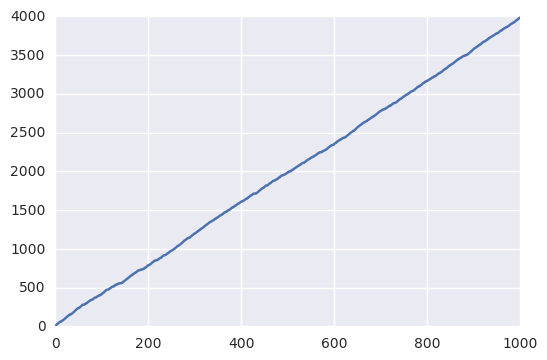

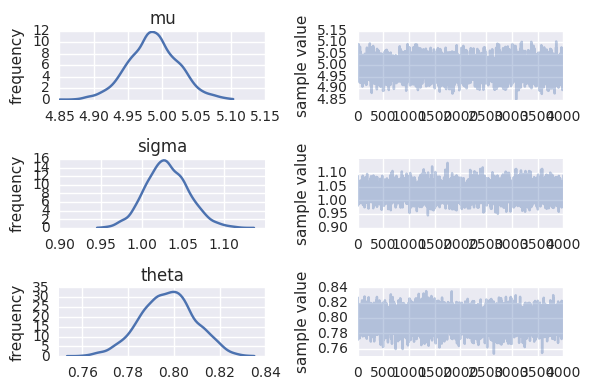

In [6]:
### Random walk, possibility of no step, positive steps, noise on no step

theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    //real out;
    //if(x<=A) {
    //  out = log(0);
    //} else {
    //  out = normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma);
    //}
    //return(out);
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += log_mix(theta, lower_truncated_normal_lpdf(Y[t+1]-Y[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(Y[t+1]-Y[t] | 0, 0.01, 0));
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b13cdc51ac03f26bda5bd61f7c201b28 NOW.


NOT reusing model.
Ran in 49.103 sec.
Inference for Stan model: anon_model_b13cdc51ac03f26bda5bd61f7c201b28.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       5.0  6.0e-4   0.03   4.93   4.98    5.0   5.02   5.07   3087    1.0
sigma   0.98  4.3e-4   0.02   0.94   0.97   0.98    1.0   1.03   3004    1.0
theta   0.79  2.2e-4   0.01   0.77   0.78   0.79    0.8   0.81   3132    1.0
lp__   -1622    0.03   1.18  -1625  -1622  -1621  -1621  -1620   1924    1.0

Samples were drawn using NUTS at Wed Nov  2 10:03:46 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


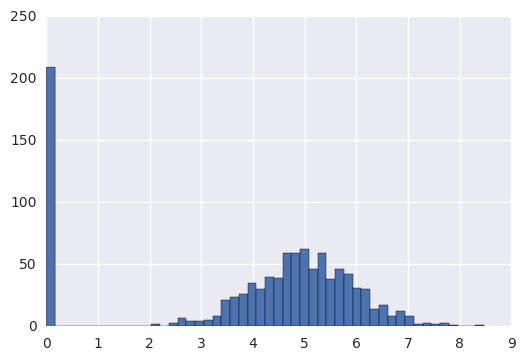

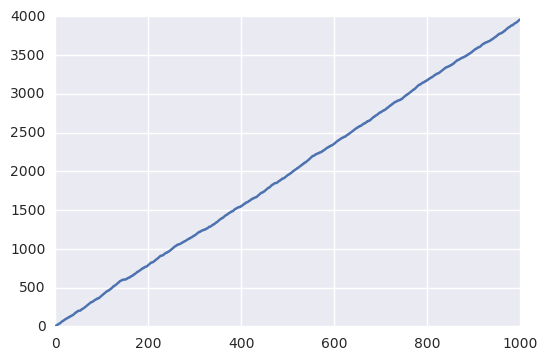

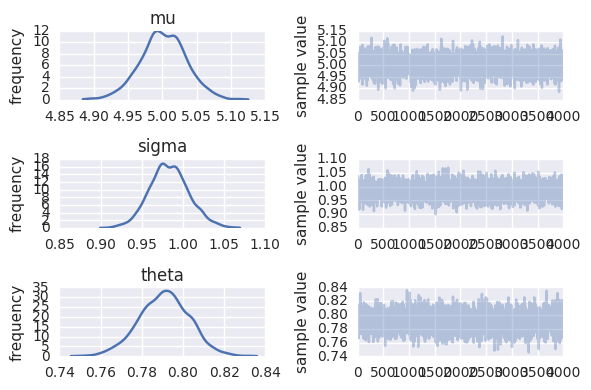

In [7]:
### Random walk, possibility of no step, positive steps, no noise on no step

theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    //real out;
    //if(x<=A) {
    //  out = log(0);
    //} else {
    //  out = normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma);
    //}
    //return(out);
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        if((Y[t+1]-Y[t])==0) {
          target += log(1-theta);
        } else {
          target += lower_truncated_normal_lpdf(Y[t+1]-Y[t] | mu, sigma, 0) + log(theta);
          }
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

Reusing model.
Ran in 38.760 sec.
Inference for Stan model: anon_model_3ec85891aaf3896834f08688bd305d1e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu   -6.1e-3    0.01    0.1   -0.2  -0.07-3.2e-3   0.06   0.18     81   1.04
sigma   0.99    0.03    0.1   0.82   0.92   0.98   1.05   1.19     11    1.2

Samples were drawn using NUTS at Thu Nov  3 03:38:00 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 120.0)

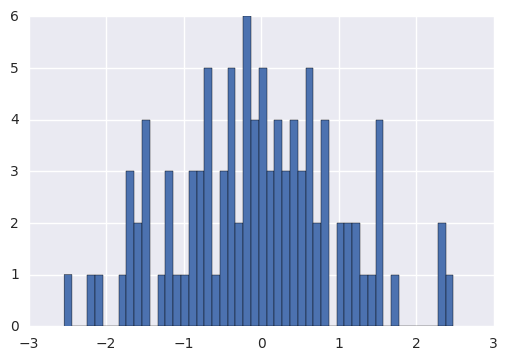

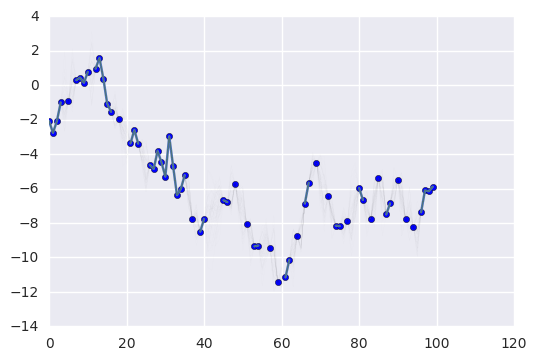

In [104]:
### Random walk, missing data, with measurement error

p_missing = .4
mu = 0
sigma = 1
n = 100

data = norm(loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real mu;
    real<lower = 0> sigma;
    vector[N-1] r; // updates

}

transformed parameters {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 2:N) {
        r[t-1] ~ normal(mu,sigma);
        if(Y[t] > -900) {
            Y[t] ~ normal(latent_Y[t], 0.01);
            //target += normal_lpdf( latent_Y[t]| Y[t], 0.01); // measurement error
            //latent_Y[t] ~ normal(Y[t], 0.001) T[0,]
        }
    }

}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

n_T = 100
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.1, color='gray', alpha=.05)
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0,xmax=n_T)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_401aef19d41e86a78c751136be21da6e NOW.


NOT reusing model.
Ran in 1183.198 sec.
Inference for Stan model: anon_model_401aef19d41e86a78c751136be21da6e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     38.78   24.33  34.41   0.02  12.51  30.43  66.73  94.26      2    nan
sigma   7.13    5.58   7.89   0.05   0.06   4.64  14.69  19.17      2    nan

Samples were drawn using NUTS at Sat Nov  5 04:11:03 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 120.0)

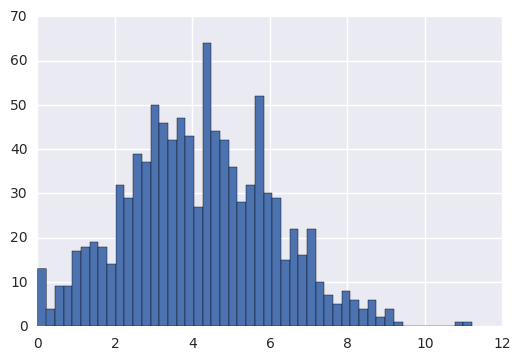

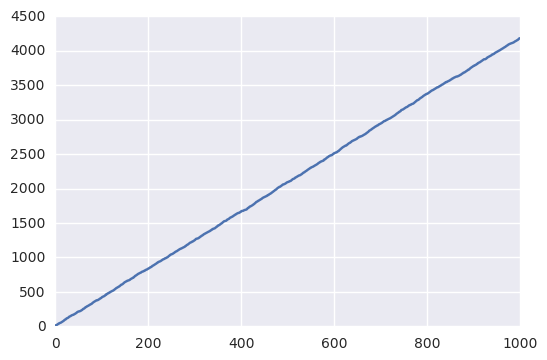

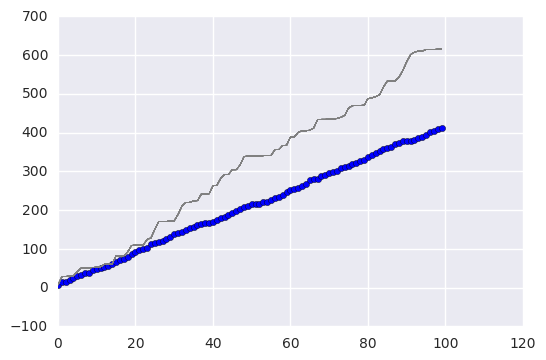

In [40]:
### Random walk, missing data, positive steps, with measurement error
### Doesn't work!

p_missing = 0
mu = 4
sigma = 2
n = 1000

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0>[N-1] r; // updates

}

transformed parameters {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 2:N) {
        r[t-1] ~ normal(mu,sigma) T[0,];
        if(Y[t] > -900) {
            latent_Y[t] ~ normal(Y[t], 0.001) T[Y[t],];
            //target += normal_lpdf( latent_Y[t]| Y[t], 0.01); // measurement error
            //latent_Y[t] ~ normal(Y[t], 0.001) T[0,]
        }
    }

}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs, init_r = 5)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

figure()
n_T = 100
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

Reusing model.
Ran in 14.078 sec.
Inference for Stan model: anon_model_1acbbef783ec08c7c0587dc043aef642.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.71    0.05   0.14   4.41   4.62   4.71    4.8   4.97     10   1.13
sigma   1.13    0.05   0.13   0.91   1.04   1.12   1.21   1.42      6   1.22
theta   0.83  6.1e-4   0.04   0.75   0.81   0.83   0.86    0.9   4000   1.05

Samples were drawn using NUTS at Thu Nov 10 08:50:06 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 160.0)

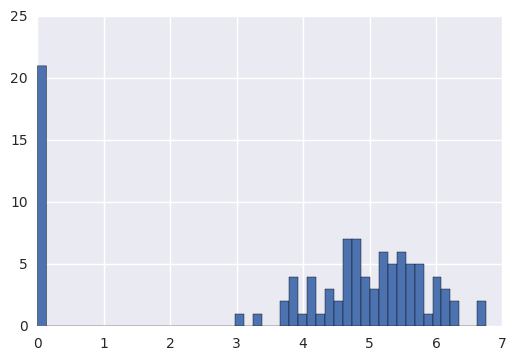

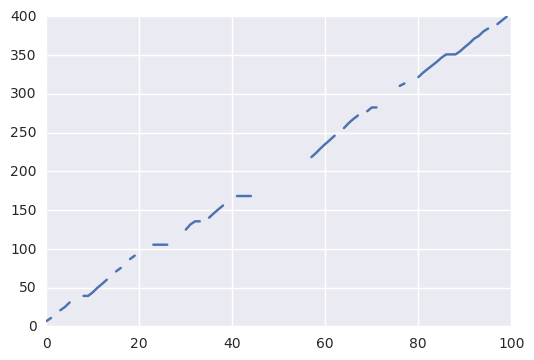

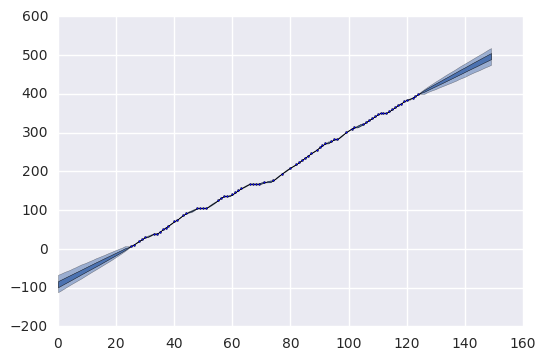

In [6]:
### Random walk, missing data, positive steps, no measurement error, possibility of no step, noise on no step
p_missing = 0.3
theta = .8
mu = 5
sigma = 1
n = 100

improvement = rand(n)<theta
improvement[0] = True

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions{
    int first_observation_ind(vector my_array){
        int t;
        t = 1;
        while(my_array[t] < -900){
          t = t+1;
        }
        return t;
    }
    
    int last_observation_ind(vector my_array, int length){
        int last_observation;
        last_observation = 0; 
        for(t in 1:length){
          if(my_array[t] > -900){
              last_observation = t;
          }
        }
        return last_observation;
    }
    
    
    int count_n_observations(vector my_array) {
        int count;
        count = 0;
        for (t in 1:num_elements(my_array)) {
            if(my_array[t] > -900){
                count = count + 1;
            }
        }
        return count;
    }
    
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
        return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
}

data {
    int N_time_periods; // number of time periods
    vector[N_time_periods] Y; // value each time period
    
    int N_time_periods_for_inference;
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
  int first_observation;
  int last_observation;
  int N_observed_time_periods_for_inference;
  int r_offset;
  int n_observations;

  first_observation = first_observation_ind(Y[1:N_time_periods_for_inference]);
  last_observation = last_observation_ind(Y[1:N_time_periods_for_inference], 
                      N_time_periods_for_inference);
                      
  N_observed_time_periods_for_inference = last_observation-first_observation + 1;
  r_offset = first_observation-1;
  
  n_observations = count_n_observations(Y);

}
  
parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    real<lower = 0, upper = 1> theta;

    vector<lower = 0,upper = 1>[N_observed_time_periods_for_inference-1] r_raw; // updates
}

transformed parameters {
  // Identify where the first and last non-missing data points are in Y
  vector<lower = 0>[N_observed_time_periods_for_inference-1] r; // updates
  
  {
  // Dictate that the total change between each pair of observations is equal to the observed change between them
  // This is relevant for time periods with missing data
  int most_recent_observation;
  most_recent_observation = first_observation;
  for(t in first_observation+1:last_observation) {
      if(Y[t] > -900) {
        r[(most_recent_observation-r_offset):((t-1)-r_offset)] = 
        r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)] /
        sum(r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)]) * 
        (Y[t]-Y[most_recent_observation]);
        most_recent_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_location, theta_prior_scale);

    for(t in 1:N_observed_time_periods_for_inference-1){
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(r[t] | 0, 0.01, 0));
    }
}

generated quantities {
    vector[N_time_periods] Y_sim;
    vector[N_time_periods] log_lik;

    //Fill out data in the missing periods
    for(t in first_observation:last_observation) {
      if(Y[t] > -900){
          Y_sim[t] = Y[t];
      } else{
          Y_sim[t] = Y_sim[t-1] + r[(t-1)-r_offset];
      } 
    }
    {
    real increase_size;
    //Fill out future data points
    for(t in last_observation+1:N_time_periods){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t] = bernoulli_rng(theta) * increase_size + Y_sim[t-1];
    }
    }
    
    //Fill out past data points
    {
    int t;
    real increase_size;
    t = first_observation;
    while(t>1){
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t-1] = Y_sim[t] - bernoulli_rng(theta) * increase_size;
        t = t-1;
    }
    }
    
    for(t in 2:N_time_periods){
        if(Y[t] > -900){
            if((Y[t]-Y_sim[t-1])==0) {
                log_lik[t] = log(1-theta);
            } else {
                log_lik[t] = log(theta) + 
                            lower_truncated_normal_lpdf(Y[t]-Y_sim[t-1]| mu, sigma, 0);
            }
        }
    }
}
"""

n_past_steps = 25
n_future_steps = 25
stan_data = {'N_time_periods': len(time_series)+n_future_steps+n_past_steps,
            'N_time_periods_for_inference': len(time_series)+n_past_steps,
             'Y': pd.Series(concatenate((empty(n_past_steps)*nan,
                                         time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
           'theta_prior_location': .8,
           'theta_prior_scale': .2,
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 0,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma','theta']))

figure()
plot_time_series_inference(model_fit)
scatter(arange(len(time_series))+n_past_steps, time_series,s=2)
xlim(xmin=0)
# ylim(ymin=0)

Reusing model.
Ran in 6.435 sec.
Inference for Stan model: anon_model_0c650f670c30afa2bd63b40e0685a916.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      3.95  3.0e-3   0.19   3.55   3.83   3.95   4.07    4.3   4000    1.0
sigma   1.82  2.8e-3   0.18   1.51   1.69    1.8   1.92   2.21   4000    1.0

Samples were drawn using NUTS at Thu Nov  3 13:53:18 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 35.0)

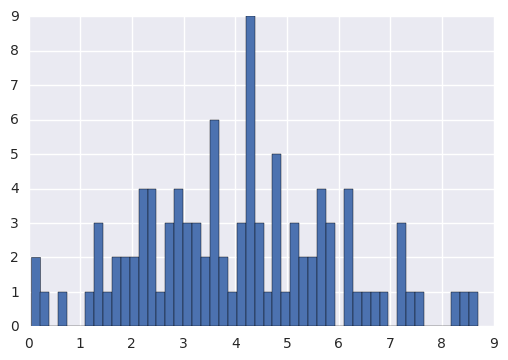

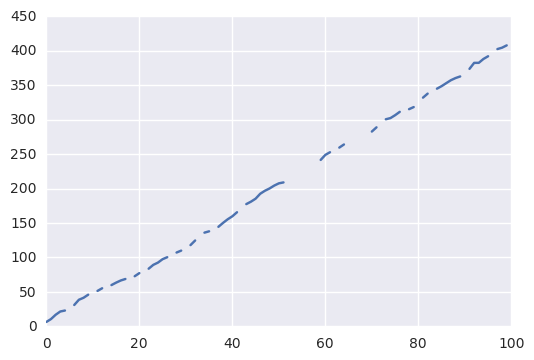

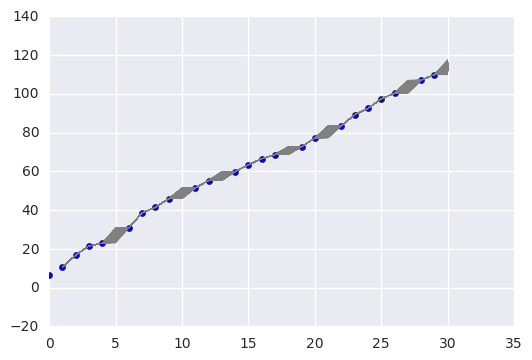

In [67]:
### Random walk, missing data, positive steps, no measurement error
p_missing = 0.3
mu = 4
sigma = 2
n = 100

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0,upper = 1>[N-1] r_raw; // updates
}

transformed parameters {
  vector<lower = 0>[N-1] r; // updates

  {
  int first_observation;
  int last_observation;
  int length_observed_time_series;
  int t;
  first_observation = 0;
  last_observation = 0;
  t = 1;
  while(first_observation=0){
      if(Y[t] > -900){
          first_observation = t;
      } else{
          t = t+1;
      }
  }
  
  t=1;
  for(t in first_observation:N){
      if(Y[t] > -900){
          last_observation = t;
  }
  
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        r[last_observation:t-1] = r_raw[last_observation:t-1]/sum(r_raw[last_observation:t-1]) * (Y[t]-Y[last_observation]);
        last_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    for(t in 1:N-1){
        r[t] ~ normal(mu,sigma) T[0,];
    }
}

generated quantities {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

figure()
n_T = 30
plot(arange(1,n_T+1),cumsum(model_fit['r'][:,:n_T].T, axis=0)+time_series[0],linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3f6121d783efbca17d4bee8a3eb3ddb NOW.


NOT reusing model.
Ran in 290.993 sec.
Inference for Stan model: anon_model_b3f6121d783efbca17d4bee8a3eb3ddb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.85  6.8e-4   0.04   4.77   4.82   4.85   4.88   4.93   4000   1.09
sigma   1.12  9.5e-3   0.04   1.05   1.09   1.12   1.14   1.19     14   1.22
theta   0.81  2.0e-4   0.01   0.78    0.8   0.81   0.82   0.84   4000   1.03

Samples were drawn using NUTS at Fri Nov  4 00:54:00 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 35.0)

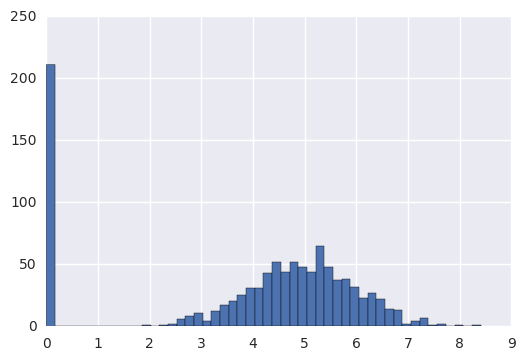

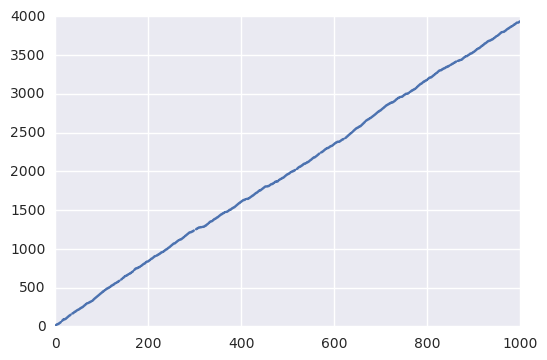

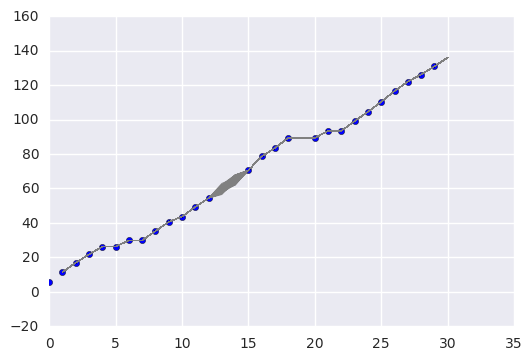

In [5]:
### Random walk, missing data, positive steps, no measurement error, possibility of no step, noise on no step
p_missing = 0.1
theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int N; // number of time periods
    vector[N] Y; // value each time period
        
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0,upper = 1>[N-1] r_raw; // updates
    real<lower = 0, upper = 1> theta;
}

transformed parameters {
  vector<lower = 0>[N-1] r; // updates
  
  {
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        r[last_observation:t-1] = r_raw[last_observation:t-1]/sum(r_raw[last_observation:t-1]) * (Y[t]-Y[last_observation]);
        last_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_location, theta_prior_scale);

    for(t in 1:N-1){
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(r[t] | 0, 0.01, 0));
    }
}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'theta_prior_location': .8,
       'theta_prior_scale': .2,
       'mu_prior_location': 5,
       'mu_prior_scale': .2,
       'sigma_prior_location': 1,
       'sigma_prior_scale': 2}
model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma', 'theta']))

figure()
n_T = 30
plot(arange(1,n_T+1),cumsum(model_fit['r'][:,:n_T].T, axis=0)+time_series[0],linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbb0aed23617f52fcc0ad1b1665b8ea7 NOW.


NOT reusing model.
Ran in 72.849 sec.
Inference for Stan model: anon_model_bbb0aed23617f52fcc0ad1b1665b8ea7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.83    0.01   0.12    4.6   4.75   4.83   4.91   5.08    111   1.03
sigma   1.37    0.01   0.13   1.15   1.28   1.36   1.45   1.65    105   1.03
theta   0.87  5.2e-4   0.03    0.8   0.85   0.87   0.89   0.92   4000   1.01

Samples were drawn using NUTS at Fri Nov  4 01:10:05 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 35.0)

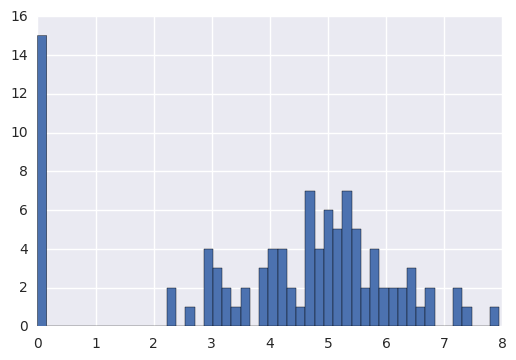

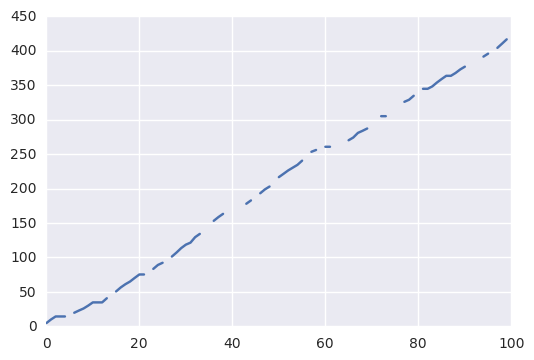

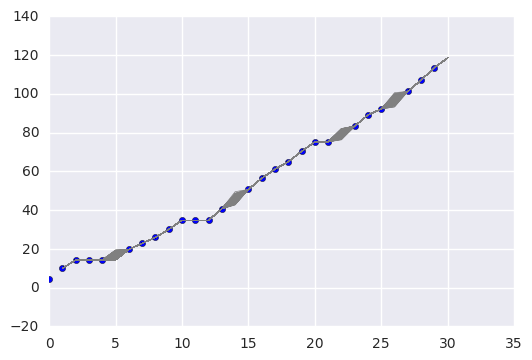

In [14]:
### Random walk, missing data, positive steps, no measurement error, possibility of no step, generate predictions
p_missing = 0.3
theta = .8
mu = 5
sigma = 1
n = 100
M = 100

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    int M; // number of future time periods to simulate
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0,upper = 1>[N-1] r_raw; // updates
    real<lower = 0, upper = 1> theta;
}

transformed parameters {
  vector<lower = 0>[N-1] r; // updates
  
  {
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        r[last_observation:t-1] = r_raw[last_observation:t-1]/sum(r_raw[last_observation:t-1]) * (Y[t]-Y[last_observation]);
        last_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_location, theta_prior_scale);

    for(t in 1:N-1){
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(r[t] | 0, 0.01, 0));
    }
}

generated quantities {
    vector[M] Y_sim;
    real last_observation;
    real increase_size;

    last_observation = Y[N];
    
    for(t in 1:M){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t] = bernoulli_rng(theta) * increase_size + last_observation;
        last_observation = Y_sim[t];
    }
}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
             'M': M,
       'theta_prior_location': .8,
       'theta_prior_scale': .2,
       'mu_prior_location': 5,
       'mu_prior_scale': .2,
       'sigma_prior_location': 1,
       'sigma_prior_scale': 2}
model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma', 'theta']))

figure()
n_T = 30
plot(arange(1,n_T+1),cumsum(model_fit['r'][:,:n_T].T, axis=0)+time_series[0],linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

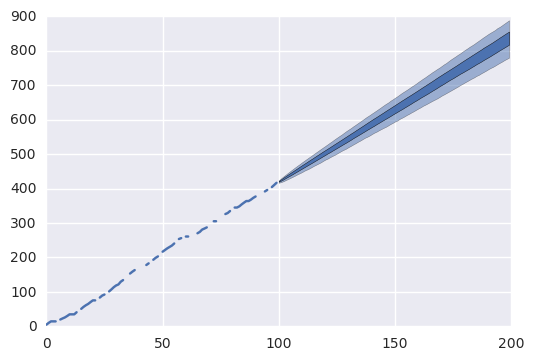

In [27]:
from scipy.stats import scoreatpercentile
ci_thresholds = [2.5, 25, 75, 97.5]
CIs = scoreatpercentile(model_fit['Y_sim'], ci_thresholds, axis=0)
CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
fill_between(arange(M)+len(time_series), CIs[2.5], CIs[97.5],alpha=.5)
fill_between(arange(M)+len(time_series), CIs[25], CIs[75])
plot(time_series)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc148974be4fa62fa38cc8f9202affe5 NOW.


NOT reusing model.
Ran in 62.188 sec.
Inference for Stan model: anon_model_fc148974be4fa62fa38cc8f9202affe5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      3.03    0.02   0.98    1.1   2.35   3.03   3.71   4.91   3011    1.0
sigma   7.48    0.73  38.09   0.09   0.87   1.98    4.5  43.48   2747    1.0
theta   0.01  1.7e-4   0.01 3.6e-4 3.3e-3 7.9e-3   0.02   0.04   4000    1.0

Samples were drawn using NUTS at Thu Nov  3 13:58:41 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 35.0)

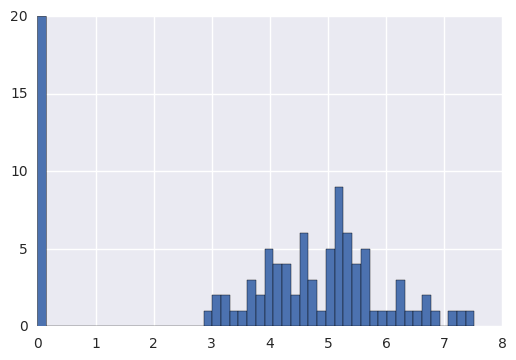

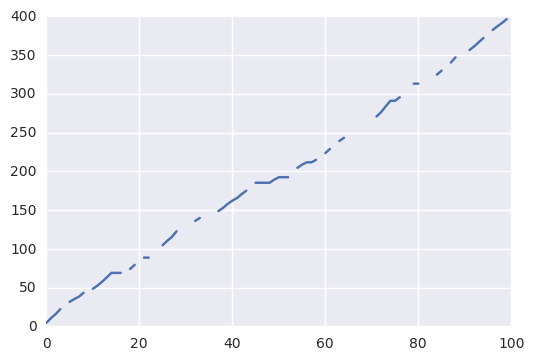

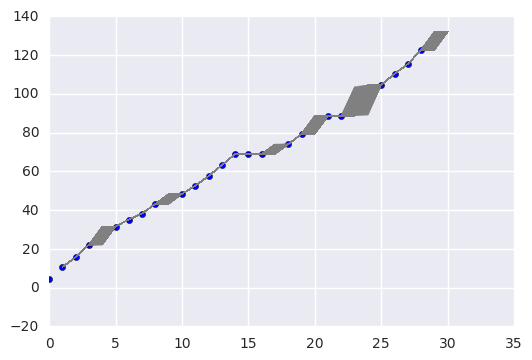

In [69]:
### Random walk, missing data, positive steps, no measurement error, possibility of no step
p_missing = .3
theta = .8
mu = 5
sigma = 1
n = 100

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0,upper = 1>[N-1] r_raw; // updates
    real<lower = 0, upper = 1> theta;
}

transformed parameters {
  vector<lower = 0>[N-1] r; // updates

  {
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        r[last_observation:t-1] = r_raw[last_observation:t-1]/sum(r_raw[last_observation:t-1]) * (Y[t]-Y[last_observation]);
        last_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_location, theta_prior_scale);

    for(t in 1:N-1){
        target += log_sum_exp(log(theta)+lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                             log(1-theta));
    }
}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}
model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma', 'theta']))

figure()
n_T = 30
plot(arange(1,n_T+1),cumsum(model_fit['r'][:,:n_T].T, axis=0)+time_series[0],linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

NOT reusing model.


ValueError: Failed to parse Stan model 'anon_model_9a5cf3e53091e932733e4729d5041612'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Illegal statement beginning with non-void expression parsed as
  r[last_observation:t]
Not a legal assignment, sampling, or function statement.  Note that
  * Assignment statements only allow variables (with optional indexes) on the left;
    if you see an outer function logical_lt (<) with negated (-) second argument,
    it indicates an assignment statement A <- B with illegal left
    side A parsed as expression (A < (-B)).
  * Sampling statements allow arbitrary value-denoting expressions on the left.
  * Functions used as statements must be declared to have void returns


ERROR at line 26

 24:          if(Y[t] > -900) {
 25:            real r_raw[t-last_observation];
 26:            r[last_observation:t] = r_raw/sum(r_raw) * (Y[t]-Y[last_observation]);
                ^
 27:            last_observation = t;

PARSER EXPECTED: "}"


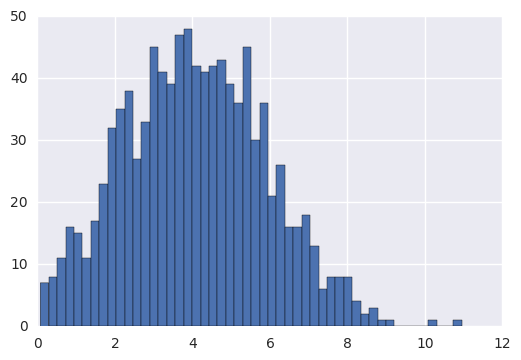

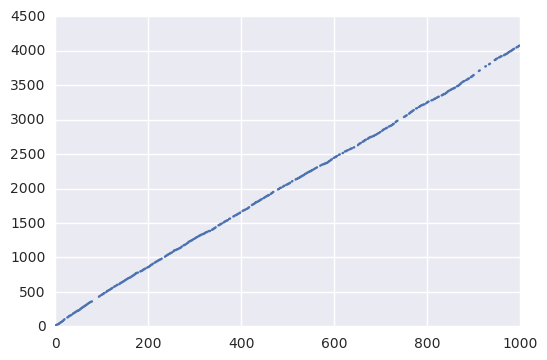

In [16]:
### Random walk, missing data, positive steps, no measurement error
p_missing = 0.3
mu = 4
sigma = 2
n = 1000

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower = 0> r[N-1]; // updates
    real<lower = 0> mu;
    real<lower = 0> sigma;
}

model {
  mu ~ normal(mu_prior_location, mu_prior_scale);
  sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        real r_raw[t-last_observation];
        sum(r[last_observation:t]) ~ = r_raw/sum(r_raw) * (Y[t]-Y[last_observation]);
        last_observation = t;
        }
    }
    r ~ normal(mu,sigma) T[0,];
}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

figure()
n_T = 100
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

NOT reusing model.


ValueError: Failed to parse Stan model 'anon_model_a7b59f67204b2800067650f0d6b2832e'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Illegal statement beginning with non-void expression parsed as
  sum(r[last_observation:t])
Not a legal assignment, sampling, or function statement.  Note that
  * Assignment statements only allow variables (with optional indexes) on the left;
    if you see an outer function logical_lt (<) with negated (-) second argument,
    it indicates an assignment statement A <- B with illegal left
    side A parsed as expression (A < (-B)).
  * Sampling statements allow arbitrary value-denoting expressions on the left.
  * Functions used as statements must be declared to have void returns


ERROR at line 34

 32:          if(Y[t] > -900) {
 33:            latent_Y[t] = Y[t];
 34:            sum(r[last_observation:t]) = Y[t] - Y[last_observation];
                ^
 35:            last_observation = t;

PARSER EXPECTED: "}"


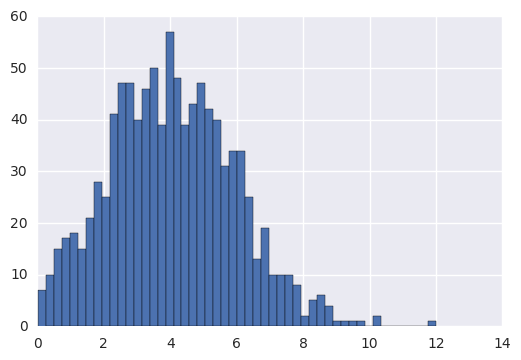

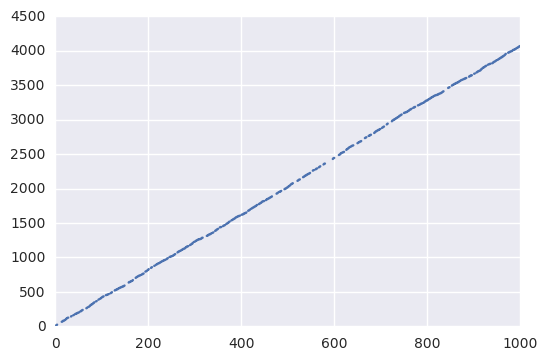

In [123]:
### Random walk, missing data, positive steps, no measurement error
p_missing = 0.3
mu = 4
sigma = 2
n = 1000

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    vector<lower = 0>[N-1] r; // updates

}

transformed parameters {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
  {
  int last_observation;
  last_observation = 1;
  for(t in 2:N) {
      if(Y[t] > -900) {
        latent_Y[t] = Y[t];
        sum(r[last_observation:t]) = Y[t] - Y[last_observation];  \\This could be handled through an array of simplexes. Seems silly, though.
        last_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 2:N) {
        r[t-1] ~ normal(mu,sigma) T[0,];
        //if(Y[t] > -900) {
          //  Y[t] ~ normal(latent_Y[t], 0.001);
            //target += normal_lpdf( latent_Y[t]| Y[t], 0.01); // measurement error
            //latent_Y[t] ~ normal(Y[t], 0.001) T[0,]
        //}
    }

}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

figure()
n_T = 100
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
xlim(xmin=0)

Reusing model.
Ran in 115.254 sec.


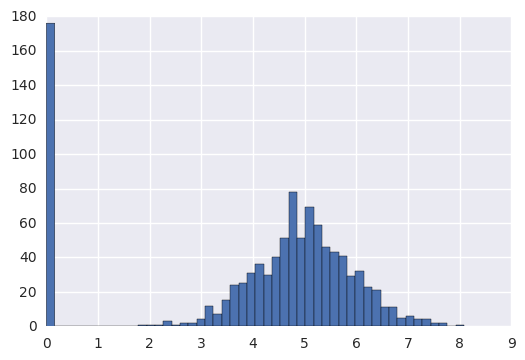

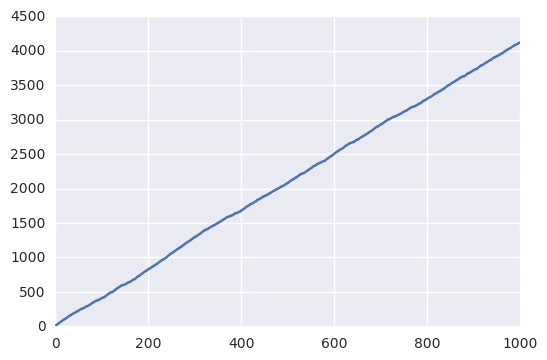

In [44]:
### Random walk, possibility of no step, positive steps, noise on no step, missing data

p_missing = 0
theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
    vector<lower = 0>[N-1] r; // updates

    
}

transformed parameters {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    
    for(t in 2:N) {
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t-1] | mu, sigma, 0.0), 
                      lower_truncated_normal_lpdf(r[t-1] | 0.0, 0.01, 0.0));
                      
        if(Y[t] > -900) {
            target += normal_lpdf( latent_Y[t]| Y[t], 0.01); // measurement error
            //latent_Y[t] ~ normal(Y[t], 0.001) T[0,]
        }
    }

}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

(0, 25.0)

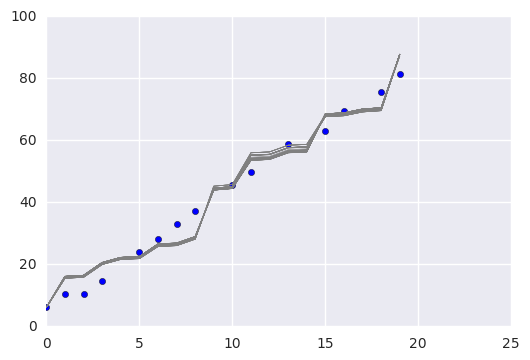

In [38]:
n_T = 20
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
ylim(ymin=0)
xlim(xmin=0)

(0, 20.0)

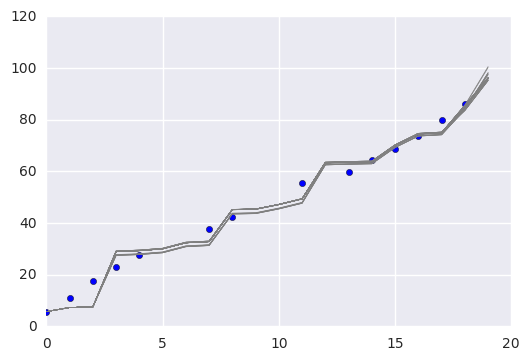

In [27]:
n_T = 20
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
ylim(ymin=0)
xlim(xmin=0)

In [ ]:
print(model_fit)
model_fit.plot()
tight_layout()

figure()
model_fit.extract('latent_Y').plot(linewidth=.5, color='gray')
scatter(time_series)